In [2]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yahoo_fin import stock_info as si
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('Set3')

import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


# Get data

In [3]:
start_date = dt.datetime.now() - dt.timedelta(days=365 * 10)
end_date = dt.datetime.now()
data = {}

companies_dow30 = si.tickers_dow()
stocks = list(companies_dow30)

# Fetch the historical data and ticker specific data
for stock in stocks:
    ticker = yf.Ticker(stock)
    hist = ticker.history(start=start_date, end=end_date)
    
    # Include additional info from the .info attribute for each day
    for date in hist.index:
        info = ticker.info
        hist.at[date, 'industry'] = info.get('industry')
        hist.at[date, 'country'] = info.get('country')
        hist.at[date, 'state'] = info.get('state')
        hist.at[date, 'exchange'] = info.get('exchange')
        hist.at[date, 'sector'] = info.get('sector')
        
    
    data[stock] = hist

# Combine and create df
all_data = pd.concat(data)

# basic df maintenance
fin_df = all_data.reset_index().copy()
fin_df.rename(columns={'level_0': 'ticker'}, inplace=True)
fin_df['date'] = fin_df['Date'].dt.strftime('%Y-%m-%d')

# Find New Metrics


In [ ]:
def rolling_avgs(df):
    df['rolling_close_60'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(60, 1).mean())
    df['rolling_close_30'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(30, 1).mean())
    df['rolling_close_10'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(10, 1).mean())

    return df


In [ ]:
fin_df = rolling_avgs(fin_df)
fin_df.head()


,ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,industry,country,state,exchange,sector,date,rolling_close_60,rolling_close_30,rolling_close_10
0,AAPL,2014-05-29 00:00:00-04:00,19.834124,20.119071,19.831596,20.072001,376474000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-05-29,20.072001,20.072001,20.072001
1,AAPL,2014-05-30 00:00:00-04:00,20.154131,20.349676,19.867289,19.996811,564020800,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-05-30,20.034406,20.034406,20.034406
2,AAPL,2014-06-02 00:00:00-04:00,20.027143,20.054626,19.665114,19.859396,369350800,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-02,19.976069,19.976069,19.976069
3,AAPL,2014-06-03 00:00:00-04:00,19.853396,20.178147,19.846762,20.140238,292709200,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-03,20.017111,20.017111,20.017111
4,AAPL,2014-06-04 00:00:00-04:00,20.137071,20.467193,20.095055,20.370209,335482000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-04,20.087731,20.087731,20.087731


In [ ]:
def calculate_rsi(data, window_size=14):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Price_Change'] = data.groupby('ticker')['Close'].diff()
    data['Gain'] = data['Price_Change'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = -data['Price_Change'].apply(lambda x: x if x < 0 else 0)
    data['Avg_Gain'] = data.groupby('ticker')['Gain'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    data['Avg_Loss'] = data.groupby('ticker')['Loss'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    data['RS'] = data['Avg_Gain'] / data['Avg_Loss']
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    return data['RSI']

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Short_EMA'] = data.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=short_window, min_periods=1, adjust=False).mean())
    data['Long_EMA'] = data.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=long_window, min_periods=1, adjust=False).mean())
    data['MACD'] = data['Short_EMA'] - data['Long_EMA']
    data['Signal_Line'] = data.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=signal_window, min_periods=1, adjust=False).mean())
    data['MACD_vs_Signal'] = data['MACD'] - data['Signal_Line']
    return data['MACD'], data['Signal_Line'], data['MACD_vs_Signal']


In [ ]:

def calculate_bollinger_bands(data, window_size=7, num_std=2):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Rolling_Mean'] = data.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=window_size).mean())
    data['Rolling_STD'] = data.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=window_size).std())
    data['Upper_Band'] = data['Rolling_Mean'] + (data['Rolling_STD'] * num_std)
    data['Lower_Band'] = data['Rolling_Mean'] - (data['Rolling_STD'] * num_std)
    return data['Upper_Band'], data['Lower_Band']

In [ ]:
# momentum oscillator that measures the speed and change of price movements. 
# The formula for RSI involves calculating average gains and losses over a specified period
fin_df['rsi'] = calculate_rsi(fin_df, window_size=14)

# MACD - momentum indicator that shows the relationship between two moving averages of a security's price.
#If MACD line goes above the Signal line it is considered a good time to invest because short term average has jumped above the long term average
macd_line, signal_line, macd_vs_signal = calculate_macd(fin_df)
fin_df['MACD'] = macd_line
fin_df['Signal_Line'] = signal_line
fin_df['MACD_vs_Signal_Line'] = macd_vs_signal

# Bollinger Bands - two outer bands that are standard deviations away from the middle band. They are used to measure volatility
upper_band, lower_band = calculate_bollinger_bands(fin_df)
fin_df['Upper_Band'] = upper_band
fin_df['Lower_Band'] = lower_band

In [ ]:
fin_df.head()

,ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,industry,...,rolling_close_60,rolling_close_30,rolling_close_10,rsi,MACD,Signal_Line,Upper_Band,Lower_Band,tomorrow_close,MACD_vs_Signal_Line
0,AAPL,2014-05-29 00:00:00-04:00,19.834124,20.119071,19.831596,20.072001,376474000,0.0,0.0,Consumer Electronics,...,20.072001,20.072001,20.072001,NaN,0.000000,0.000000,NaN,NaN,19.996811,0.000000
1,AAPL,2014-05-30 00:00:00-04:00,20.154131,20.349676,19.867289,19.996811,564020800,0.0,0.0,Consumer Electronics,...,20.034406,20.034406,20.034406,NaN,-0.005998,-0.001200,NaN,NaN,19.859396,-0.004798
2,AAPL,2014-06-02 00:00:00-04:00,20.027143,20.054626,19.665114,19.859396,369350800,0.0,0.0,Consumer Electronics,...,19.976069,19.976069,19.976069,NaN,-0.021591,-0.005278,NaN,NaN,20.140238,-0.016313
3,AAPL,2014-06-03 00:00:00-04:00,19.853396,20.178147,19.846762,20.140238,292709200,0.0,0.0,Consumer Electronics,...,20.017111,20.017111,20.017111,NaN,-0.011158,-0.006454,NaN,NaN,20.370209,-0.004704
4,AAPL,2014-06-04 00:00:00-04:00,20.137071,20.467193,20.095055,20.370209,335482000,0.0,0.0,Consumer Electronics,...,20.087731,20.087731,20.087731,NaN,0.015488,-0.002065,NaN,NaN,20.450138,0.017554


In [ ]:
fin_df['tomorrow_close'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].shift(-1)
fin_df = fin_df.dropna(subset=['tomorrow_close'])


In [ ]:

features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
            'rolling_close_60', 'rolling_close_30', 'rolling_close_10',
            'rsi', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']

X = fin_df[features]
y = fin_df['tomorrow_close']


# Plot data by ticker


Text(0, 0.5, 'Closing Price')

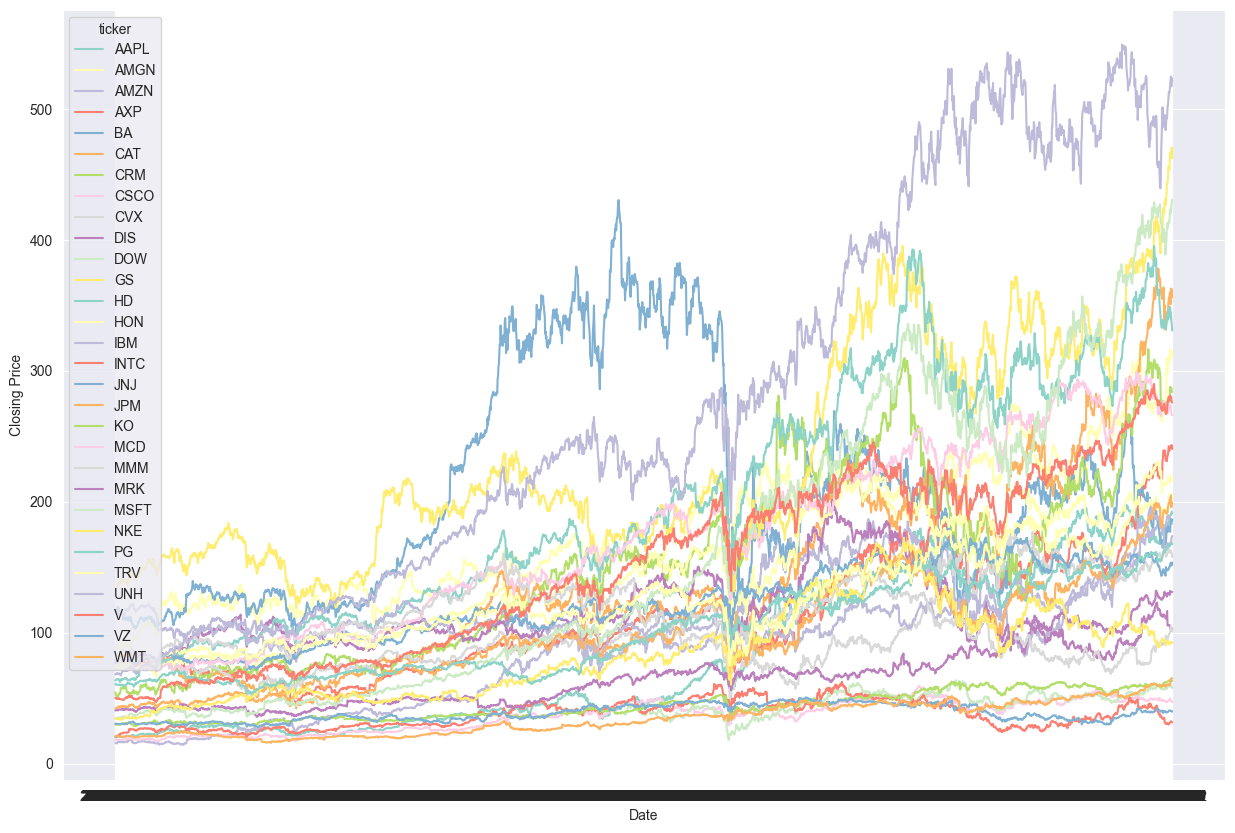

In [ ]:
palette = sns.color_palette("Set3", n_colors=30)
plt.figure(figsize=(15,10))
sns.lineplot(data=fin_df, x = 'date', y = 'Close', hue='ticker', palette=palette)
plt.xlabel('Date')
plt.ylabel('Closing Price')


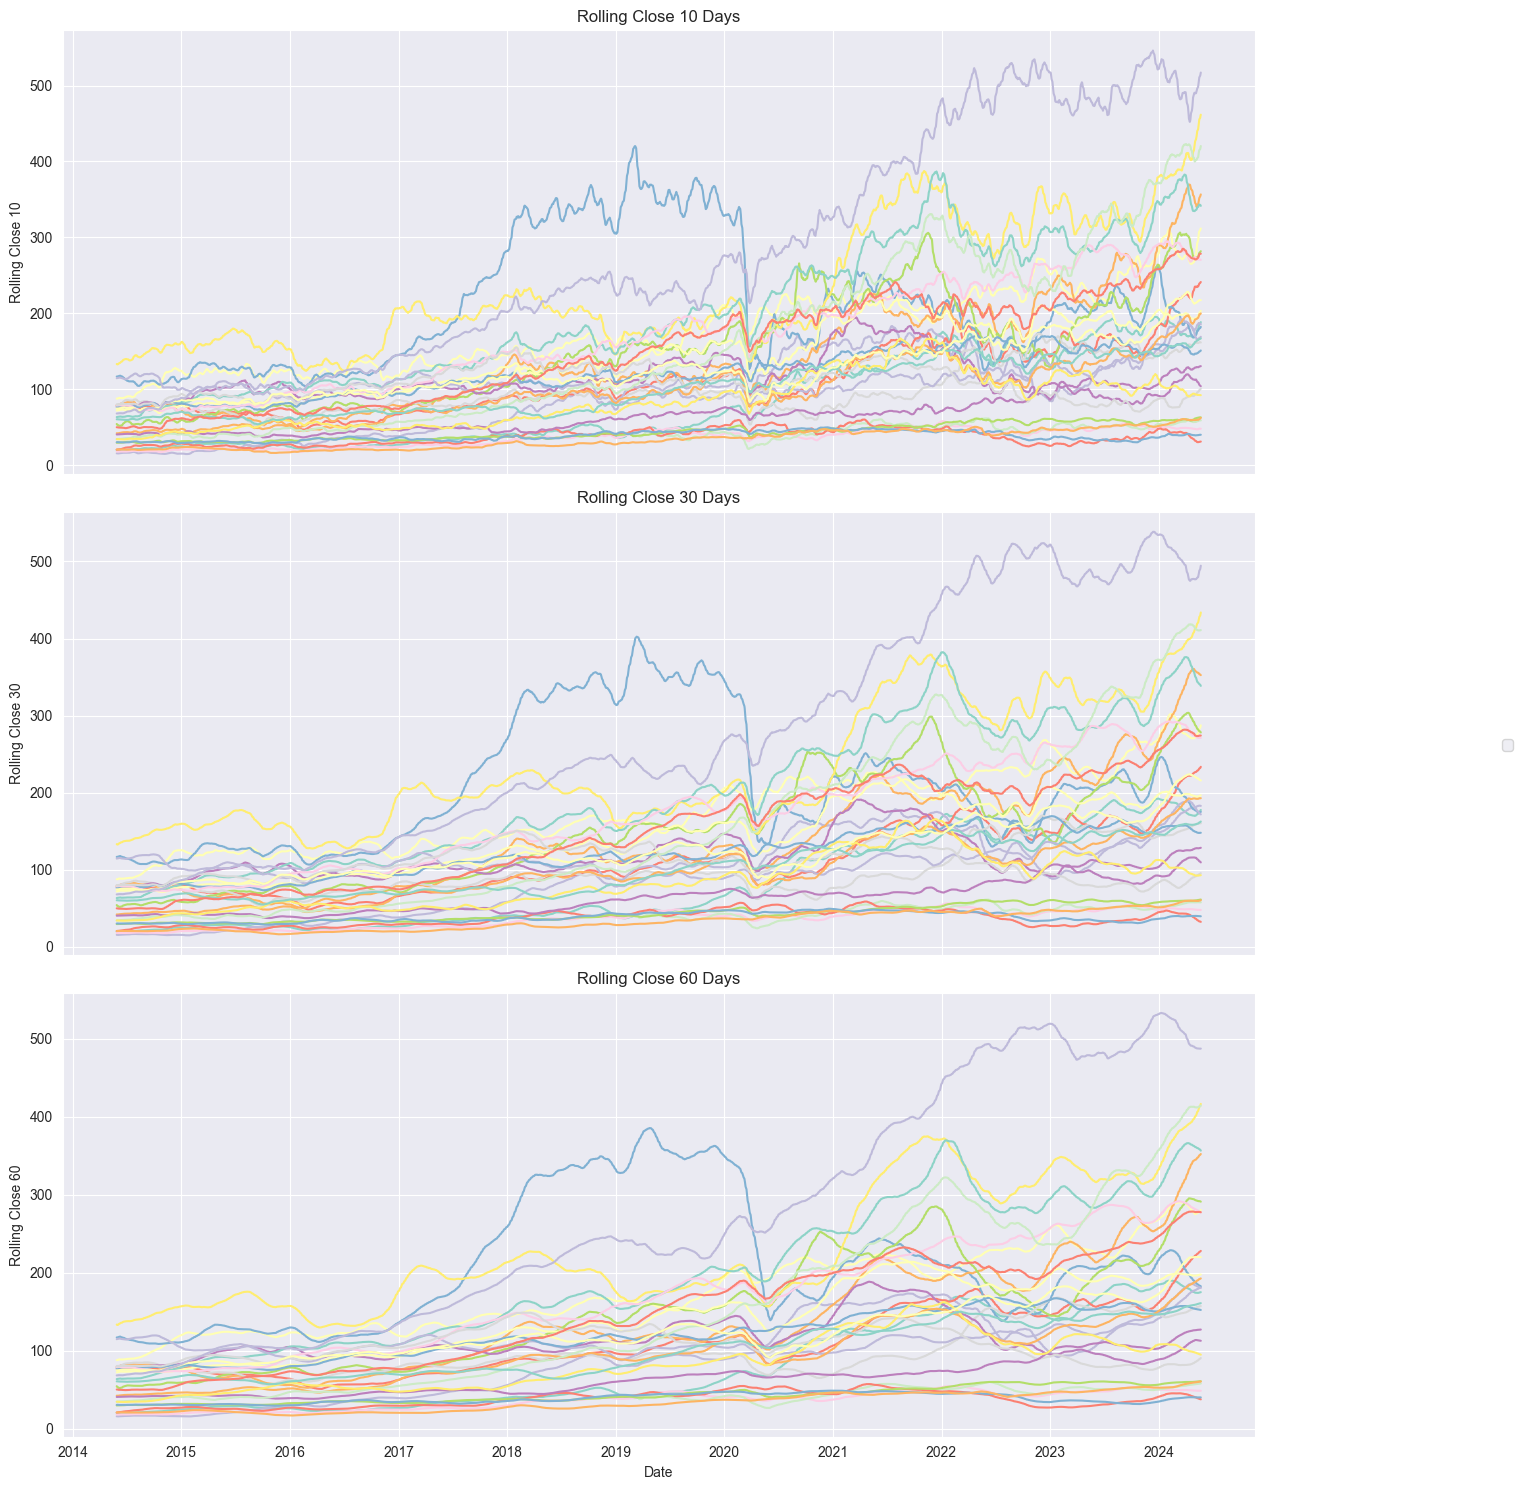

In [ ]:
palette = sns.color_palette("Set3", n_colors=30)
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Plotting rolling_close_10
sns.lineplot(data=fin_df, x='Date', y='rolling_close_10', hue='ticker', palette=palette, ax=axes[0], legend=None)
axes[0].set_title('Rolling Close 10 Days')
axes[0].set_xlabel('')
axes[0].set_ylabel('Rolling Close 10')

# Plotting rolling_close_30
sns.lineplot(data=fin_df, x='Date', y='rolling_close_30', hue='ticker', palette=palette, ax=axes[1], legend=None)
axes[1].set_title('Rolling Close 30 Days')
axes[1].set_xlabel('')
axes[1].set_ylabel('Rolling Close 30')

# Plotting rolling_close_60
sns.lineplot(data=fin_df, x='Date', y='rolling_close_60', hue='ticker', palette=palette, ax=axes[2], legend=None)
axes[2].set_title('Rolling Close 60 Days')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Rolling Close 60')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1]) 

# Display the plot
plt.show()

In [ ]:
num_rows = len(stocks)
fig, axes = plt.subplots(num_rows, 1, figsize=(15, 3*num_rows), sharex=False)

# Plot each stock in a separate subplot
for i, stock in enumerate(stocks):
    stock_data = fin_df[fin_df['ticker'] == stock]
    sns.histplot(data=stock_data, x='date', y='MACD_vs_Signal_Line', bins=10, ax=axes[i])
    axes[i].set_title(f'{stock} MACD vs Signal Line')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('MACD vs Signal Line')
    axes[i].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[i].fill_betweenx(y=np.arange(0, 300), x1=0, x2=macd_vs_signal.max(), color='green', alpha=0.3)
    axes[i].fill_betweenx(y=np.arange(0, 300), x1=macd_vs_signal.min(), x2=0, color='red', alpha=0.3)


# Adjust layout to avoid overlap
plt.tight_layout()


Error in callback <function _draw_all_if_interactive at 0x14f93ade0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
aapl = fin_df[fin_df['ticker'] == 'AAPL']
aapl['date'].describe()

NameError: name 'fin_df' is not defined